## RQ1

C:\Users\iansy\AppData\Local\Temp\ipykernel_26116\1073143299.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Index(['Testbed', 'Algorithm', 'Bug No.', 'Bug File', 'Bug category',
       'Real life bug?', 'Fuzzy Oracle Pass Rate', 'Human Oracle Pass Rate'],
      dtype='object')


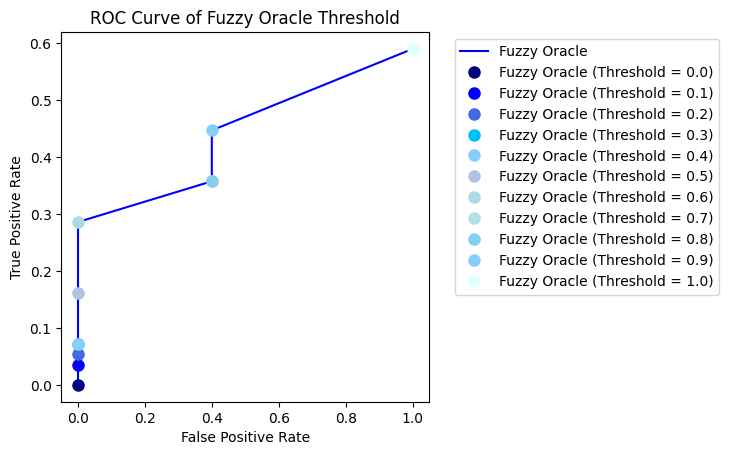

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
import matplotlib.pyplot as plt


# 定义计算评估指标的函数
def calculate_metrics(y_true, y_pred, threshold):
    tp = sum((y_true == 'Positive') & (y_pred == 'Positive'))
    tn = sum((y_true == 'Negative') & (y_pred == 'Negative'))
    fp = sum((y_true == 'Negative') & (y_pred == 'Positive'))
    fn = sum((y_true == 'Positive') & (y_pred == 'Negative'))
    
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * tpr) / (precision + tpr) if (precision + tpr) > 0 else 0
    
    return [threshold, tpr, fpr, accuracy, precision, f1]

# 定义绘制ROC曲线的函数
def plot_roc_curve(fpr, tpr, thresholds, label, color, point_colors):
    plt.plot(fpr, tpr, label=label, color=color)
    
    # 选择要标注的阈值
    selected_thresholds = np.arange(0, 1.1, 0.1)
    
    for i, threshold in enumerate(selected_thresholds):
        idx = np.argmin(np.abs(thresholds - threshold))
        plt.plot(fpr[idx], tpr[idx], 'o', markersize=8, label=f'{label} (Threshold = {threshold:.1f})', color=point_colors[i])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


# 读取CSV文件
# data = pd.read_csv('Oracle Result 2_New.csv', skiprows=1, header=0)
data = pd.read_csv('Oracle Result (Slope as test oracle).csv', skiprows=1, header=0)

# 定义阈值范围
thresholds = np.arange(0, 1.1, 0.1)

# 初始化结果数组
fuzzy_results = []

print(data.columns)

# 获取真实标签
data['True_Label'] = data['Bug No.'].apply(lambda x: 'Negative' if x == 'bug-free' else 'Positive')

# 对每个阈值进行分析
for threshold in thresholds:
    # 根据阈值计算Fuzzy Oracle的判定结果
    data['Fuzzy_Prediction'] = data['Fuzzy Oracle Pass Rate'].apply(lambda x: 'Negative' if x >= threshold else 'Positive')
    
    # 计算评估指标
    fuzzy_metrics = calculate_metrics(data['True_Label'], data['Fuzzy_Prediction'], threshold)
    
    # 存储结果
    fuzzy_results.append(fuzzy_metrics)


# 将结果转换为DataFrame
fuzzy_df = pd.DataFrame(fuzzy_results, columns=['Threshold', 'TPR', 'FPR', 'Accuracy', 'Precision', 'F1'])

# 定义阈值点的颜色
fuzzy_point_colors = ['navy', 'blue', 'royalblue', 'deepskyblue', 'lightskyblue', 'lightsteelblue', 'lightblue', 'powderblue', 'skyblue', 'lightskyblue', 'lightcyan', 'paleturquoise']

# 绘制ROC曲线
plot_roc_curve(fuzzy_df['FPR'], fuzzy_df['TPR'], fuzzy_df['Threshold'], 'Fuzzy Oracle', 'blue', fuzzy_point_colors)

plt.title('ROC Curve of Fuzzy Oracle Threshold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(right=0.7)

# plt.xlim(0, 1.1)  # X轴固定在0-1范围
# plt.ylim(0, 1.1)  # Y轴固定在0-1范围
plt.show()


# 计算AUC值
fuzzy_auc = auc(fuzzy_df['FPR'], fuzzy_df['TPR'])

# print(f"Fuzzy Oracle AUC: {fuzzy_auc:.2f}")

## RQ2

In [2]:
import pandas as pd

# 读取CSV文件
data = pd.read_csv('Oracle Result (Slope as test oracle).csv', skiprows=1, header=0)

# 定义阈值
fuzzy_threshold = 0.7

# 根据阈值计算Fuzzy Oracle的预测结果
data['Fuzzy_Prediction'] = data['Fuzzy Oracle Pass Rate'].apply(lambda x: 'No Problem' if x >= fuzzy_threshold else 'Problem')

# 获取真实标签
data['True_Label'] = data['Bug No.'].apply(lambda x: 'Negative' if x == 'bug-free' else 'Positive')

# 计算混淆矩阵
confusion_matrix = pd.crosstab(data['True_Label'], data['Fuzzy_Prediction'], rownames=['True Label'], colnames=['Fuzzy Prediction'])

# 计算性能指标
true_positive = confusion_matrix.loc['Positive', 'Problem']
false_positive = confusion_matrix.loc['Negative', 'Problem']
true_negative = confusion_matrix.loc['Negative', 'No Problem']
false_negative = confusion_matrix.loc['Positive', 'No Problem']

# 按环境和算法分组计算性能指标
performance_by_group = data.groupby(['Testbed', 'Algorithm']).apply(lambda x: pd.Series({
    'True Positive': len(x[(x['True_Label'] == 'Positive') & (x['Fuzzy_Prediction'] == 'Problem')]),
    'False Positive': len(x[(x['True_Label'] == 'Negative') & (x['Fuzzy_Prediction'] == 'Problem')]),
    'True Negative': len(x[(x['True_Label'] == 'Negative') & (x['Fuzzy_Prediction'] == 'No Problem')]),
    'False Negative': len(x[(x['True_Label'] == 'Positive') & (x['Fuzzy_Prediction'] == 'No Problem')])
}))

# 打印结果
print("Confusion Matrix:")
print(confusion_matrix)
print("\nPerformance by Environment and Algorithm:")
print(performance_by_group)

Confusion Matrix:
Fuzzy Prediction  No Problem  Problem
True Label                           
Negative                   5        0
Positive                  40       16

Performance by Environment and Algorithm:
                                   True Positive  False Positive  \
Testbed                 Algorithm                                  
Frozen Lake             A2C                    1               0   
                        DQN                    4               0   
                        PPO                    1               0   
Mountaincar Continuous  A2C                    0               0   
                        PPO                    0               0   
Mountaincar Continuous  A2C                    8               0   
                        PPO                    2               0   

                                   True Negative  False Negative  
Testbed                 Algorithm                                 
Frozen Lake             A2C             

C:\Users\iansy\AppData\Local\Temp\ipykernel_26116\1038770434.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  performance_by_group = data.groupby(['Testbed', 'Algorithm']).apply(lambda x: pd.Series({


In [3]:
import pandas as pd

# 读取CSV文件
data = pd.read_csv('Oracle Result (Slope as test oracle).csv', skiprows=1, header=0)

# 定义阈值
fuzzy_threshold = 0.7

# 根据阈值计算Fuzzy Oracle的预测结果
data['Fuzzy_Prediction'] = data['Fuzzy Oracle Pass Rate'].apply(lambda x: 'No Problem' if x >= fuzzy_threshold else 'Problem')

# 获取真实标签
data['True_Label'] = data['Bug No.'].apply(lambda x: 'Negative' if x == 'bug-free' else 'Positive')

# 计算混淆矩阵
confusion_matrix = pd.crosstab(data['True_Label'], data['Fuzzy_Prediction'], rownames=['True Label'], colnames=['Fuzzy Prediction'])

# 计算性能指标
true_positive = confusion_matrix.loc['Positive', 'Problem']
false_positive = confusion_matrix.loc['Negative', 'Problem']
true_negative = confusion_matrix.loc['Negative', 'No Problem']
false_negative = confusion_matrix.loc['Positive', 'No Problem']

# 按环境分组计算性能指标
performance_by_env = data.groupby('Testbed').apply(lambda x: pd.Series({
    'True Positive': len(x[(x['True_Label'] == 'Positive') & (x['Fuzzy_Prediction'] == 'Problem')]),
    'False Positive': len(x[(x['True_Label'] == 'Negative') & (x['Fuzzy_Prediction'] == 'Problem')]),
    'True Negative': len(x[(x['True_Label'] == 'Negative') & (x['Fuzzy_Prediction'] == 'No Problem')]),
    'False Negative': len(x[(x['True_Label'] == 'Positive') & (x['Fuzzy_Prediction'] == 'No Problem')])
}))

# 按算法分组计算性能指标
performance_by_algo = data.groupby('Algorithm').apply(lambda x: pd.Series({
    'True Positive': len(x[(x['True_Label'] == 'Positive') & (x['Fuzzy_Prediction'] == 'Problem')]),
    'False Positive': len(x[(x['True_Label'] == 'Negative') & (x['Fuzzy_Prediction'] == 'Problem')]),
    'True Negative': len(x[(x['True_Label'] == 'Negative') & (x['Fuzzy_Prediction'] == 'No Problem')]),
    'False Negative': len(x[(x['True_Label'] == 'Positive') & (x['Fuzzy_Prediction'] == 'No Problem')])
}))

# 打印结果
print("Confusion Matrix:")
print(confusion_matrix)

print("\nPerformance by Environment:")
print(performance_by_env)

print("\nPerformance by Algorithm:")
print(performance_by_algo)

Confusion Matrix:
Fuzzy Prediction  No Problem  Problem
True Label                           
Negative                   5        0
Positive                  40       16

Performance by Environment:
                         True Positive  False Positive  True Negative  \
Testbed                                                                 
Frozen Lake                          6               0              3   
Mountaincar Continuous               0               0              2   
Mountaincar Continuous              10               0              0   

                         False Negative  
Testbed                                  
Frozen Lake                          30  
Mountaincar Continuous                0  
Mountaincar Continuous               10  

Performance by Algorithm:
           True Positive  False Positive  True Negative  False Negative
Algorithm                                                              
A2C                    9               0              

C:\Users\iansy\AppData\Local\Temp\ipykernel_26116\658067463.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  performance_by_env = data.groupby('Testbed').apply(lambda x: pd.Series({
C:\Users\iansy\AppData\Local\Temp\ipykernel_26116\658067463.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  performance_by_algo = data.groupby('Algorithm').apply(lambda x: pd.Series({


## RQ3

In [4]:
import pandas as pd

# 读取CSV文件
data = pd.read_csv('Oracle Result (Slope as test oracle).csv', skiprows=1, header=0)

# 定义阈值
fuzzy_threshold = 0.7

# 根据阈值计算Fuzzy Oracle的预测结果
data['Fuzzy_Prediction'] = data['Fuzzy Oracle Pass Rate'].apply(lambda x: 'No Problem' if x >= fuzzy_threshold else 'Problem')

# 获取真实标签
data['True_Label'] = data['Bug No.'].apply(lambda x: 'Negative' if x == 'bug-free' else 'Positive')

# 过滤掉没有bug的样本
data_with_bugs = data[data['True_Label'] == 'Positive']

# 按Bug类型分组计算性能指标
performance_by_bug_type = data_with_bugs.groupby('Bug category').apply(lambda x: pd.Series({
    'True Positive': len(x[(x['True_Label'] == 'Positive') & (x['Fuzzy_Prediction'] == 'Problem')]),
    'False Negative': len(x[(x['True_Label'] == 'Positive') & (x['Fuzzy_Prediction'] == 'No Problem')])
})).fillna(0).astype(int)

# 计算每个Bug类型的Recall
performance_by_bug_type['Recall'] = performance_by_bug_type['True Positive'] / (performance_by_bug_type['True Positive'] + performance_by_bug_type['False Negative'])

# 打印每个Bug类型的Recall
# Recall = 正确识别出的有bug的RL程序数 / 实际有bug的RL程序总数
print("Recall by Bug Category:")
for bug_type in performance_by_bug_type.index:
    recall = performance_by_bug_type.loc[bug_type, 'Recall']
    print(f"Bug Category: {bug_type}")
    print(f"Recall: {recall:.2f}")
    print()

Recall by Bug Category:
Bug Category: Exploring the enviroment
Recall: 0.00

Bug Category: Model
Recall: 0.33

Bug Category: Training
Recall: 0.20

Bug Category: Training Loss function
Recall: 0.46

Bug Category: Training Optimizer
Recall: 0.29

Bug Category: Updating network
Recall: 0.25



C:\Users\iansy\AppData\Local\Temp\ipykernel_26116\155688642.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  performance_by_bug_type = data_with_bugs.groupby('Bug category').apply(lambda x: pd.Series({


In [5]:
import pandas as pd

# 读取CSV文件
data = pd.read_csv('Oracle Result (Slope as test oracle).csv', skiprows=1, header=0)

# 定义阈值
fuzzy_threshold = 0.7

# 根据阈值计算Fuzzy Oracle的预测结果
data['Fuzzy_Prediction'] = data['Fuzzy Oracle Pass Rate'].apply(lambda x: 'No Problem' if x >= fuzzy_threshold else 'Problem')

# 获取真实标签
data['True_Label'] = data['Bug No.'].apply(lambda x: 'Negative' if x == 'bug-free' else 'Positive')

# 过滤掉没有bug的样本
data_with_bugs = data[data['True_Label'] == 'Positive']

# 将Training Loss function和Training Optimizer归类为Training的子类
data_with_bugs.loc[data_with_bugs['Bug category'].isin(['Training Loss function', 'Training Optimizer']), 'Bug category'] = 'Training'

# 按Bug类型分组计算性能指标
performance_by_bug_type = data_with_bugs.groupby('Bug category').apply(lambda x: pd.Series({
    'True Positive': len(x[(x['True_Label'] == 'Positive') & (x['Fuzzy_Prediction'] == 'Problem')]),
    'False Negative': len(x[(x['True_Label'] == 'Positive') & (x['Fuzzy_Prediction'] == 'No Problem')])
})).fillna(0).astype(int)

# 计算每个Bug类型的Recall
performance_by_bug_type['Recall'] = performance_by_bug_type['True Positive'] / (performance_by_bug_type['True Positive'] + performance_by_bug_type['False Negative'])

# 打印每个Bug类型的Recall
# Recall = 正确识别出的有bug的RL程序数 / 实际有bug的RL程序总数
print("Recall by Bug Category:")
for bug_type in performance_by_bug_type.index:
    recall = performance_by_bug_type.loc[bug_type, 'Recall']
    print(f"Bug Category: {bug_type}")
    print(f"Recall: {recall:.2f}")
    print()

Recall by Bug Category:
Bug Category: Exploring the enviroment
Recall: 0.00

Bug Category: Model
Recall: 0.33

Bug Category: Training
Recall: 0.30

Bug Category: Updating network
Recall: 0.25



C:\Users\iansy\AppData\Local\Temp\ipykernel_26116\710880311.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  performance_by_bug_type = data_with_bugs.groupby('Bug category').apply(lambda x: pd.Series({


## RQ4

In [6]:
import pandas as pd

# 读取CSV文件
data = pd.read_csv('Oracle Result (Slope as test oracle).csv', skiprows=1, header=0)

# 获取真实标签
data['True_Label'] = data['Bug No.'].apply(lambda x: 'Negative' if x == 'bug-free' else 'Positive')

# 根据阈值计算Fuzzy Oracle和Human Oracle的判定结果
data['Fuzzy_Prediction'] = data['Fuzzy Oracle Pass Rate'].apply(lambda x: 'Negative' if x >= 0.7 else 'Positive')
data['Human_Prediction'] = data['Human Oracle Pass Rate'].apply(lambda x: 'Negative' if x > 0.5 else 'Positive')

# 定义计算评估指标的函数
def calculate_metrics(y_true, y_pred):
    tp = sum((y_true == 'Positive') & (y_pred == 'Positive'))
    tn = sum((y_true == 'Negative') & (y_pred == 'Negative'))
    fp = sum((y_true == 'Negative') & (y_pred == 'Positive'))
    fn = sum((y_true == 'Positive') & (y_pred == 'Negative'))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return [tp, fp, tn, fn, accuracy, precision, recall, f1]

# 获取不同的Environment
environments = data['Testbed'].unique()

# 在不同的Environment中计算两种方法的优劣性
for env in environments:
    env_data = data[data['Testbed'] == env]
    
    # 计算Fuzzy Oracle的评估指标
    fuzzy_metrics = calculate_metrics(env_data['True_Label'], env_data['Fuzzy_Prediction'])
    print(f"Environment: {env}")
    print("Fuzzy Oracle:")
    print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(*fuzzy_metrics))
    
    # 计算Human Oracle的评估指标
    human_metrics = calculate_metrics(env_data['True_Label'], env_data['Human_Prediction'])
    print("Human Oracle:")
    print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(*human_metrics))

Environment: Frozen Lake
Fuzzy Oracle:
Accuracy: 6.00, Precision: 0.00, Recall: 3.00, F1 Score: 30.00
Human Oracle:
Accuracy: 23.00, Precision: 1.00, Recall: 2.00, F1 Score: 13.00
Environment: Mountaincar Continuous 
Fuzzy Oracle:
Accuracy: 10.00, Precision: 0.00, Recall: 0.00, F1 Score: 10.00
Human Oracle:
Accuracy: 8.00, Precision: 0.00, Recall: 0.00, F1 Score: 12.00
Environment: Mountaincar Continuous
Fuzzy Oracle:
Accuracy: 0.00, Precision: 0.00, Recall: 2.00, F1 Score: 0.00
Human Oracle:
Accuracy: 0.00, Precision: 0.00, Recall: 2.00, F1 Score: 0.00


In [7]:
import pandas as pd
import numpy as np

# 读取CSV文件
data = pd.read_csv('Oracle Result (Slope as test oracle).csv', skiprows=1, header=0)

# 获取真实标签
data['True_Label'] = data['Bug No.'].apply(lambda x: 'Negative' if x == 'bug-free' else 'Positive')

# 根据阈值计算Fuzzy Oracle和Human Oracle的判定结果
data['Fuzzy_Prediction'] = data['Fuzzy Oracle Pass Rate'].apply(lambda x: 'Negative' if x >= 0.7 else 'Positive')
data['Human_Prediction'] = data['Human Oracle Pass Rate'].apply(lambda x: 'Negative' if x > 0.5 else 'Positive')

# 将'Training'、'Training Loss function'和'Training Optimizer'合并为'Training'类别
data['Bug category'] = data['Bug category'].apply(lambda x: 'Training' if x in ['Training', 'Training Loss function', 'Training Optimizer'] else x)

# 只保留有bug的条目
data = data[data['True_Label'] == 'Positive']

# 定义计算检出率的函数
def calculate_recall(y_true, y_pred):
    tp = sum((y_true == 'Positive') & (y_pred == 'Positive'))
    fn = sum((y_true == 'Positive') & (y_pred == 'Negative'))
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    return recall

# 获取不同的Bug Category
bug_categories = data['Bug category'].unique()

# 创建字典来存储每个Oracle在不同Bug Category上的检出率
fuzzy_recall_dict = {}
human_recall_dict = {}

# 在不同的Bug Category中计算两种方法的检出率
for category in bug_categories:
    category_data = data[data['Bug category'] == category]
    
    if len(category_data) == 0:
        continue
    
    # 计算Fuzzy Oracle在该Bug Category上的检出率
    fuzzy_recall = calculate_recall(category_data['True_Label'], category_data['Fuzzy_Prediction'])
    fuzzy_recall_dict[category] = fuzzy_recall
    
    # 计算Human Oracle在该Bug Category上的检出率
    human_recall = calculate_recall(category_data['True_Label'], category_data['Human_Prediction'])
    human_recall_dict[category] = human_recall
    
    print(f"Bug Category: {category}")
    print(f"Fuzzy Oracle Recall: {fuzzy_recall:.2f}")
    print(f"Human Oracle Recall: {human_recall:.2f}")
    print("---")

# 比较两种Oracle在不同Bug Category上的检出率
print("Fuzzy Oracle's strengths:")
for category, recall in fuzzy_recall_dict.items():
    if recall > human_recall_dict[category]:
        print(f"{category}: Fuzzy Oracle has higher recall than Human Oracle")

print("\nHuman Oracle's strengths:")
for category, recall in human_recall_dict.items():
    if recall > fuzzy_recall_dict[category]:
        print(f"{category}: Human Oracle has higher recall than Fuzzy Oracle")

Bug Category: Updating network
Fuzzy Oracle Recall: 0.25
Human Oracle Recall: 0.50
---
Bug Category: Training
Fuzzy Oracle Recall: 0.30
Human Oracle Recall: 0.55
---
Bug Category: Model
Fuzzy Oracle Recall: 0.33
Human Oracle Recall: 0.50
---
Bug Category: Exploring the enviroment
Fuzzy Oracle Recall: 0.00
Human Oracle Recall: 1.00
---
Fuzzy Oracle's strengths:

Human Oracle's strengths:
Updating network: Human Oracle has higher recall than Fuzzy Oracle
Training: Human Oracle has higher recall than Fuzzy Oracle
Model: Human Oracle has higher recall than Fuzzy Oracle
Exploring the enviroment: Human Oracle has higher recall than Fuzzy Oracle


In [8]:
import pandas as pd
import numpy as np

# 读取CSV文件
data = pd.read_csv('Oracle Result (Slope as test oracle).csv', skiprows=1, header=0)

# 获取真实标签
data['True_Label'] = data['Bug No.'].apply(lambda x: 'Negative' if x == 'bug-free' else 'Positive')

# 根据阈值计算Fuzzy Oracle和Human Oracle的判定结果
data['Fuzzy_Prediction'] = data['Fuzzy Oracle Pass Rate'].apply(lambda x: 'Negative' if x >= 0.7 else 'Positive')
data['Human_Prediction'] = data['Human Oracle Pass Rate'].apply(lambda x: 'Negative' if x > 0.5 else 'Positive')

# 定义计算评估指标的函数
def calculate_metrics(y_true, y_pred):
    tp = sum((y_true == 'Positive') & (y_pred == 'Positive'))
    tn = sum((y_true == 'Negative') & (y_pred == 'Negative'))
    fp = sum((y_true == 'Negative') & (y_pred == 'Positive'))
    fn = sum((y_true == 'Positive') & (y_pred == 'Negative'))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    mcc_numerator = (tp * tn) - (fp * fn)
    mcc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc = mcc_numerator / mcc_denominator if mcc_denominator != 0 else 0
    
    return [tp, fp, tn, fn, accuracy, precision, recall, f1, mcc]

# 获取不同的Algorithm
algorithms = data['Algorithm'].unique()

# 在不同的Algorithm中计算两种方法的优劣性
for algo in algorithms:
    algo_data = data[data['Algorithm'] == algo]
    
    if len(algo_data) == 0:
        continue
    
    # 计算Fuzzy Oracle的评估指标
    fuzzy_metrics = calculate_metrics(algo_data['True_Label'], algo_data['Fuzzy_Prediction'])
    print(f"Algorithm: {algo}")
    print("Fuzzy Oracle:")
    print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}".format(*fuzzy_metrics))
    
    # 计算Human Oracle的评估指标
    human_metrics = calculate_metrics(algo_data['True_Label'], algo_data['Human_Prediction'])
    print("Human Oracle:")
    print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}".format(*human_metrics))
    print('----')

Algorithm: A2C
Fuzzy Oracle:
Accuracy: 9.00, Precision: 0.00, Recall: 2.00, F1: 9.00
Human Oracle:
Accuracy: 8.00, Precision: 0.00, Recall: 2.00, F1: 10.00
----
Algorithm: DQN
Fuzzy Oracle:
Accuracy: 4.00, Precision: 0.00, Recall: 1.00, F1: 11.00
Human Oracle:
Accuracy: 13.00, Precision: 1.00, Recall: 0.00, F1: 2.00
----
Algorithm: PPO
Fuzzy Oracle:
Accuracy: 3.00, Precision: 0.00, Recall: 2.00, F1: 20.00
Human Oracle:
Accuracy: 10.00, Precision: 0.00, Recall: 2.00, F1: 13.00
----


In [9]:
import pandas as pd

# 读取CSV文件
data = pd.read_csv('Oracle Result (Slope as test oracle).csv', skiprows=1, header=0)

# 获取真实标签
data['True_Label'] = data['Bug No.'].apply(lambda x: 'Negative' if x == 'bug-free' else 'Positive')

# 根据阈值计算Fuzzy Oracle和Human Oracle的判定结果
data['Fuzzy_Prediction'] = data['Fuzzy Oracle Pass Rate'].apply(lambda x: 'Negative' if x >= 0.7 else 'Positive')
data['Human_Prediction'] = data['Human Oracle Pass Rate'].apply(lambda x: 'Negative' if x > 0.5 else 'Positive')

# 定义计算评估指标的函数
import numpy as np

def calculate_metrics(y_true, y_pred):
    tp = sum((y_true == 'Positive') & (y_pred == 'Positive'))
    tn = sum((y_true == 'Negative') & (y_pred == 'Negative'))
    fp = sum((y_true == 'Negative') & (y_pred == 'Positive'))
    fn = sum((y_true == 'Positive') & (y_pred == 'Negative'))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    mcc_numerator = (tp * tn) - (fp * fn)
    mcc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc = mcc_numerator / mcc_denominator if mcc_denominator != 0 else 0
    
    return [accuracy, precision, recall, f1, mcc]

# 获取不同的Environment和Algorithm
environments = data['Testbed'].unique()
algorithms = data['Algorithm'].unique()

# 在不同的Environment和Algorithm组合中计算两种方法的优劣性
for env in environments:
    for algo in algorithms:
        env_algo_data = data[(data['Testbed'] == env) & (data['Algorithm'] == algo)]
        
        if len(env_algo_data) == 0:
            continue
        
        # 计算Fuzzy Oracle的评估指标
        fuzzy_metrics = calculate_metrics(env_algo_data['True_Label'], env_algo_data['Fuzzy_Prediction'])
        print(f"Environment: {env}, Algorithm: {algo}")
        print("Fuzzy Oracle:")
        # print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}".format(*fuzzy_metrics))
        print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}".format(*fuzzy_metrics))
        
        # 计算Human Oracle的评估指标
        human_metrics = calculate_metrics(env_algo_data['True_Label'], env_algo_data['Human_Prediction'])
        print("Human Oracle:")
        # print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}".format(*human_metrics))
        print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}".format(*human_metrics))
        print('----')
        


Environment: Frozen Lake, Algorithm: A2C
Fuzzy Oracle:
Accuracy: 0.20, Precision: 1.00, Recall: 0.11, F1: 0.20
Human Oracle:
Accuracy: 0.50, Precision: 1.00, Recall: 0.44, F1: 0.62
----
Environment: Frozen Lake, Algorithm: DQN
Fuzzy Oracle:
Accuracy: 0.31, Precision: 1.00, Recall: 0.27, F1: 0.42
Human Oracle:
Accuracy: 0.81, Precision: 0.93, Recall: 0.87, F1: 0.90
----
Environment: Frozen Lake, Algorithm: PPO
Fuzzy Oracle:
Accuracy: 0.15, Precision: 1.00, Recall: 0.08, F1: 0.15
Human Oracle:
Accuracy: 0.54, Precision: 1.00, Recall: 0.50, F1: 0.67
----
Environment: Mountaincar Continuous , Algorithm: A2C
Fuzzy Oracle:
Accuracy: 0.89, Precision: 1.00, Recall: 0.89, F1: 0.94
Human Oracle:
Accuracy: 0.44, Precision: 1.00, Recall: 0.44, F1: 0.62
----
Environment: Mountaincar Continuous , Algorithm: PPO
Fuzzy Oracle:
Accuracy: 0.18, Precision: 1.00, Recall: 0.18, F1: 0.31
Human Oracle:
Accuracy: 0.36, Precision: 1.00, Recall: 0.36, F1: 0.53
----
Environment: Mountaincar Continuous, Algorithm

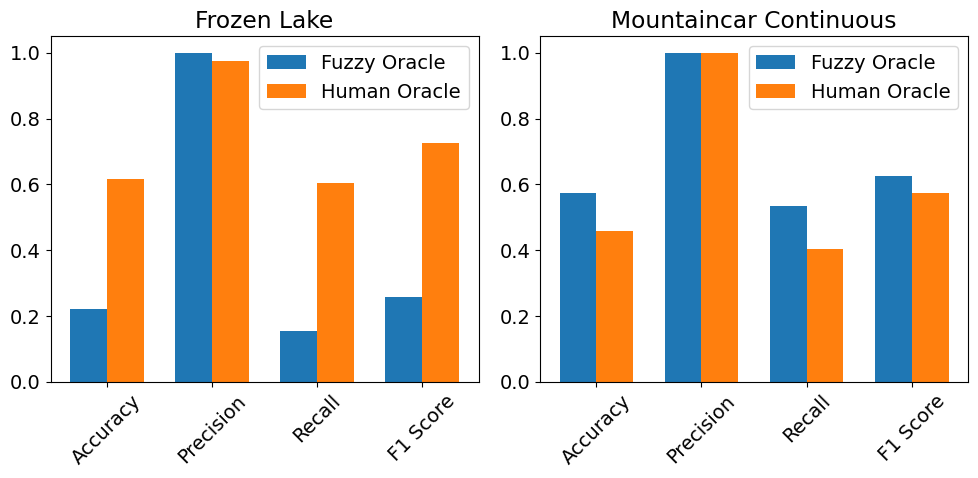

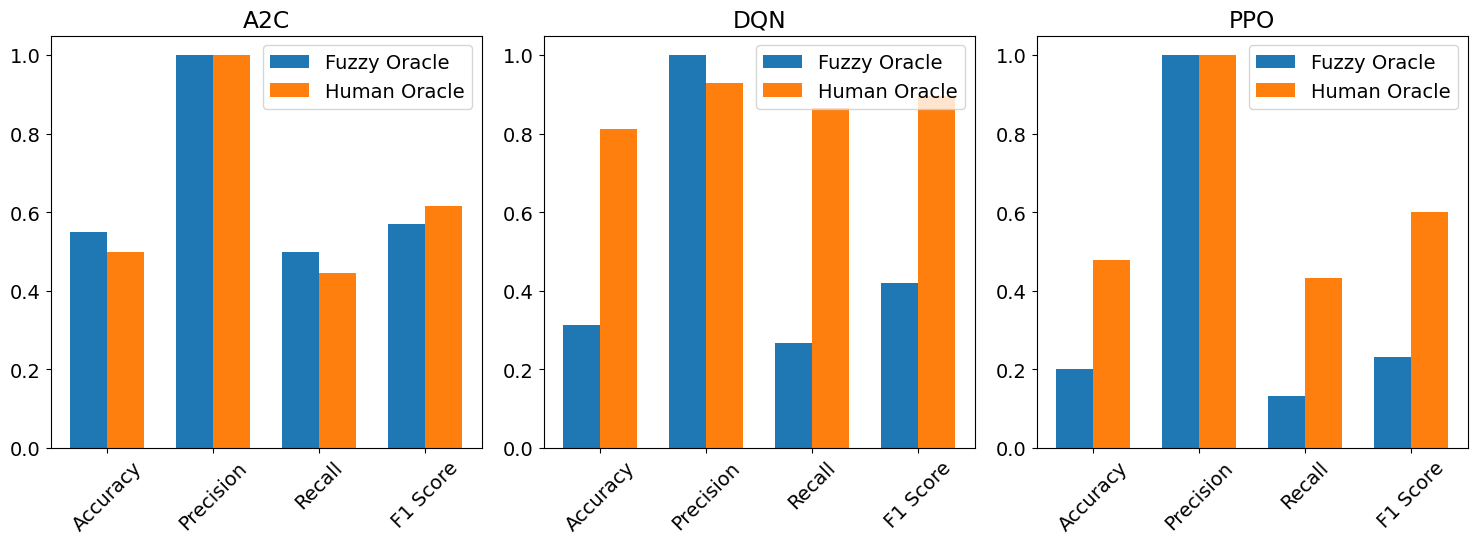

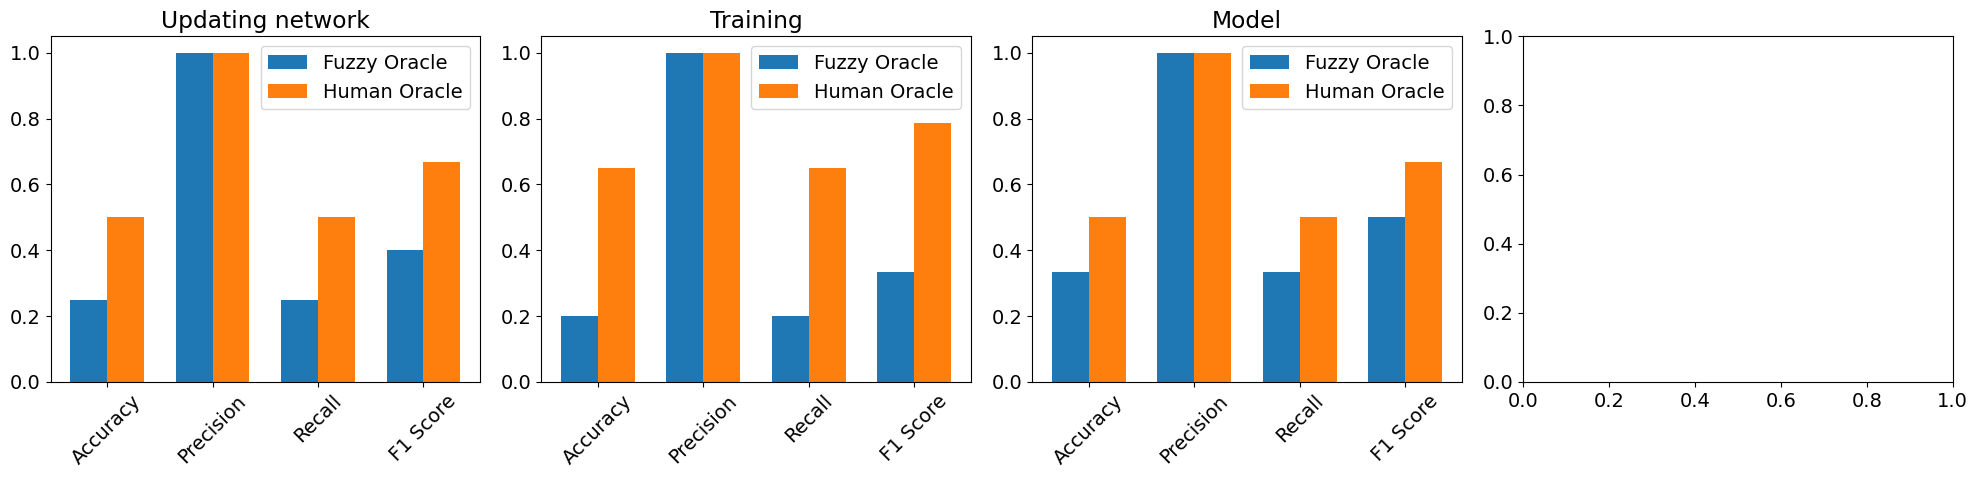

Fuzzy Oracle Metrics:
Frozen Lake - A2C: [0.2, 1.0, 0.11, 0.2]
Frozen Lake - DQN: [0.31, 1.0, 0.27, 0.42]
Frozen Lake - PPO: [0.15, 1.0, 0.08, 0.15]
Frozen Lake: [0.22, 1.0, 0.15, 0.26]
Mountaincar Continuous - A2C: [0.9, 1.0, 0.89, 0.94]
Mountaincar Continuous - PPO: [0.25, 1.0, 0.18, 0.31]
Mountaincar Continuous: [0.57, 1.0, 0.54, 0.62]
A2C: [0.55, 1.0, 0.5, 0.57]
DQN: [0.31, 1.0, 0.27, 0.42]
PPO: [0.2, 1.0, 0.13, 0.23]
Updating network: [0.25, 1.0, 0.25, 0.4]
Training: [0.2, 1.0, 0.2, 0.33]
Model: [0.33, 1.0, 0.33, 0.5]

Human Oracle Metrics:
Frozen Lake - A2C: [0.5, 1.0, 0.44, 0.62]
Frozen Lake - DQN: [0.81, 0.93, 0.87, 0.9]
Frozen Lake - PPO: [0.54, 1.0, 0.5, 0.67]
Frozen Lake: [0.62, 0.98, 0.6, 0.73]
Mountaincar Continuous - A2C: [0.5, 1.0, 0.44, 0.62]
Mountaincar Continuous - PPO: [0.42, 1.0, 0.36, 0.53]
Mountaincar Continuous: [0.46, 1.0, 0.4, 0.57]
A2C: [0.5, 1.0, 0.44, 0.62]
DQN: [0.81, 0.93, 0.87, 0.9]
PPO: [0.48, 1.0, 0.43, 0.6]
Updating network: [0.5, 1.0, 0.5, 0.67]
Train

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取CSV文件
data = pd.read_csv('Oracle Result (Slope as test oracle).csv', skiprows=1, header=0)

# 获取真实标签
data['True_Label'] = data['Bug No.'].apply(lambda x: 'Negative' if x == 'bug-free' else 'Positive')

# 根据阈值计算Fuzzy Oracle和Human Oracle的判定结果
data['Fuzzy_Prediction'] = data['Fuzzy Oracle Pass Rate'].apply(lambda x: 'Negative' if x >= 0.7 else 'Positive')
data['Human_Prediction'] = data['Human Oracle Pass Rate'].apply(lambda x: 'Negative' if x > 0.5 else 'Positive')

# 定义计算评估指标的函数
def calculate_metrics(y_true, y_pred):
    tp = sum((y_true == 'Positive') & (y_pred == 'Positive'))
    tn = sum((y_true == 'Negative') & (y_pred == 'Negative'))
    fp = sum((y_true == 'Negative') & (y_pred == 'Positive'))
    fn = sum((y_true == 'Positive') & (y_pred == 'Negative'))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return [accuracy, precision, recall, f1]

# 初始化存储结果的字典
fuzzy_metrics = {}
human_metrics = {}

# 获取不同的Environment和Algorithm
environments = data['Testbed'].unique()
algorithms = data['Algorithm'].unique()
bug_categories = ['Updating network', 'Training', 'Model', 'Exploring the environment']

# 在不同的Environment和Algorithm组合中计算两种方法的优劣性
for env in environments:
    # 存储环境级别的指标
    env_fuzzy = []
    env_human = []
    
    for algo in algorithms:
        env_algo_data = data[(data['Testbed'] == env) & (data['Algorithm'] == algo)]
        
        if len(env_algo_data) == 0:
            continue
        
        # 计算Fuzzy Oracle的评估指标
        fuzzy_results = calculate_metrics(env_algo_data['True_Label'], env_algo_data['Fuzzy_Prediction'])
        fuzzy_metrics[f"{env} - {algo}"] = fuzzy_results
        env_fuzzy.append(fuzzy_results)
        
        # 计算Human Oracle的评估指标
        human_results = calculate_metrics(env_algo_data['True_Label'], env_algo_data['Human_Prediction'])
        human_metrics[f"{env} - {algo}"] = human_results
        env_human.append(human_results)
    
    # 计算环境级别的平均指标
    if env_fuzzy:
        fuzzy_metrics[env] = np.mean(env_fuzzy, axis=0).tolist()
    if env_human:
        human_metrics[env] = np.mean(env_human, axis=0).tolist()

# 计算算法级别的平均指标
for algo in algorithms:
    algo_fuzzy = []
    algo_human = []
    
    for env in environments:
        key = f"{env} - {algo}"
        if key in fuzzy_metrics:
            algo_fuzzy.append(fuzzy_metrics[key])
        if key in human_metrics:
            algo_human.append(human_metrics[key])
    
    if algo_fuzzy:
        fuzzy_metrics[algo] = np.mean(algo_fuzzy, axis=0).tolist()
    if algo_human:
        human_metrics[algo] = np.mean(algo_human, axis=0).tolist()

# 计算Bug类别的平均指标
for category in bug_categories:
    category_data = data[data['Bug category'] == category]
    
    if not category_data.empty:
        fuzzy_results = calculate_metrics(category_data['True_Label'], category_data['Fuzzy_Prediction'])
        human_results = calculate_metrics(category_data['True_Label'], category_data['Human_Prediction'])
        
        fuzzy_metrics[category] = fuzzy_results
        human_metrics[category] = human_results

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# 设置字体大小
plt.rcParams.update({'font.size': 14})

# 1. 绘制不同环境下的性能比较
fig, axs = plt.subplots(1, len(environments), figsize=(5*len(environments), 5))
if len(environments) == 1:
    axs = [axs]  # 确保单个环境时也能正确处理

for i, env in enumerate(environments):
    if env in fuzzy_metrics and env in human_metrics:
        x = np.arange(len(metrics))
        width = 0.35
        
        axs[i].bar(x - width/2, fuzzy_metrics[env], width, label='Fuzzy Oracle')
        axs[i].bar(x + width/2, human_metrics[env], width, label='Human Oracle')
        axs[i].set_title(env)
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(metrics, rotation=45)
        axs[i].set_ylim(0, 1.05)
        axs[i].legend()

plt.tight_layout()
plt.savefig('environment_comparison.png', dpi=300)
plt.show()

# 2. 绘制不同算法下的性能比较
if len(algorithms) > 0:
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(max(2, len(algorithms)//2 + 1), min(3, len(algorithms)))
    
    for i, algo in enumerate(algorithms):
        if algo in fuzzy_metrics and algo in human_metrics:
            row = i // min(3, len(algorithms))
            col = i % min(3, len(algorithms))
            ax = fig.add_subplot(gs[row, col])
            
            x = np.arange(len(metrics))
            width = 0.35
            
            ax.bar(x - width/2, fuzzy_metrics[algo], width, label='Fuzzy Oracle')
            ax.bar(x + width/2, human_metrics[algo], width, label='Human Oracle')
            ax.set_title(algo)
            ax.set_xticks(x)
            ax.set_xticklabels(metrics, rotation=45)
            ax.set_ylim(0, 1.05)
            ax.legend()

    plt.tight_layout()
    plt.savefig('algorithm_comparison.png', dpi=300)
    plt.show()

# 3. 绘制不同Bug类别的性能比较
if len(bug_categories) > 0:
    fig, axs = plt.subplots(1, len(bug_categories), figsize=(5*len(bug_categories), 5))
    if len(bug_categories) == 1:
        axs = [axs]
    
    for i, category in enumerate(bug_categories):
        if category in fuzzy_metrics and category in human_metrics:
            x = np.arange(len(metrics))
            width = 0.35
            
            axs[i].bar(x - width/2, fuzzy_metrics[category], width, label='Fuzzy Oracle')
            axs[i].bar(x + width/2, human_metrics[category], width, label='Human Oracle')
            axs[i].set_title(category)
            axs[i].set_xticks(x)
            axs[i].set_xticklabels(metrics, rotation=45)
            axs[i].set_ylim(0, 1.05)
            axs[i].legend()

    plt.tight_layout()
    plt.savefig('bug_category_comparison.png', dpi=300)
    plt.show()

# 打印计算结果
print("Fuzzy Oracle Metrics:")
for key, value in fuzzy_metrics.items():
    print(f"{key}: {[round(v, 2) for v in value]}")
    
print("\nHuman Oracle Metrics:")
for key, value in human_metrics.items():
    print(f"{key}: {[round(v, 2) for v in value]}")